<a href="https://colab.research.google.com/github/m11dedhia/potato-disease-model/blob/master/potato_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/training-data",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

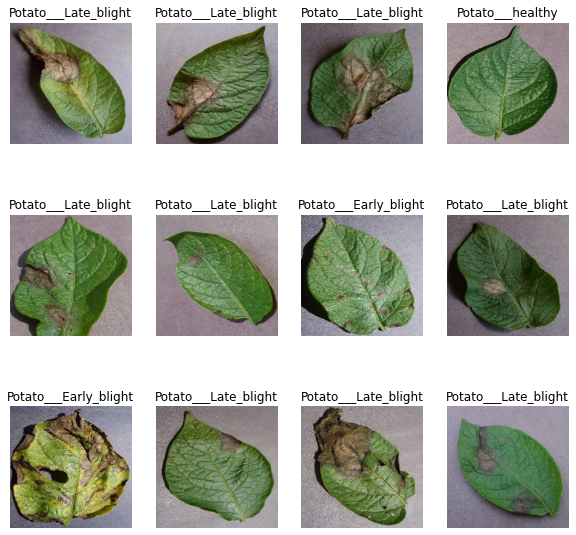

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [ ]:
# train_ds = dataset.take(54)
# test_ds = dataset.skip(54)
# val_ds = test_ds.take(6)
# test_ds = test_ds.skip(6)

def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
  ds_size = len(ds)

  if (shuffle):
    ds = ds.shuffle(shuffle_size, seed=9)

  train_size = int(ds_size * train_split)
  val_size = int(ds_size * val_split)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
 data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
 ])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax"),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 272s 146ms/step - loss: 0.8996 - accuracy: 0.4994 - val_loss: 0.8669 - val_accuracy: 0.4688
Epoch 2/50
54/54 [==============================] - 4s 68ms/step - loss: 0.8246 - accuracy: 0.5634 - val_loss: 0.7366 - val_accuracy: 0.6094
Epoch 3/50
54/54 [==============================] - 4s 68ms/step - loss: 0.6336 - accuracy: 0.7007 - val_loss: 0.5945 - val_accuracy: 0.7083
Epoch 4/50
54/54 [==============================] - 4s 68ms/step - loss: 0.5262 - accuracy: 0.7653 - val_loss: 0.5427 - val_accuracy: 0.7188
Epoch 5/50
54/54 [==============================] - 4s 68ms/step - loss: 0.3955 - accuracy: 0.8380 - val_loss: 0.3944 - val_accuracy: 0.8229
Epoch 6/50
54/54 [==============================] - 4s 68ms/step - loss: 0.3147 - accuracy: 0.8627 - val_loss: 0.3630 - val_accuracy: 0.8438
Epoch 7/50
54/54 [==============================] - 4s 68ms/step - loss: 0.3162 - accuracy: 0.8615 - val_loss: 0.3531 - val_accuracy: 0.8542
Epoch 8/50

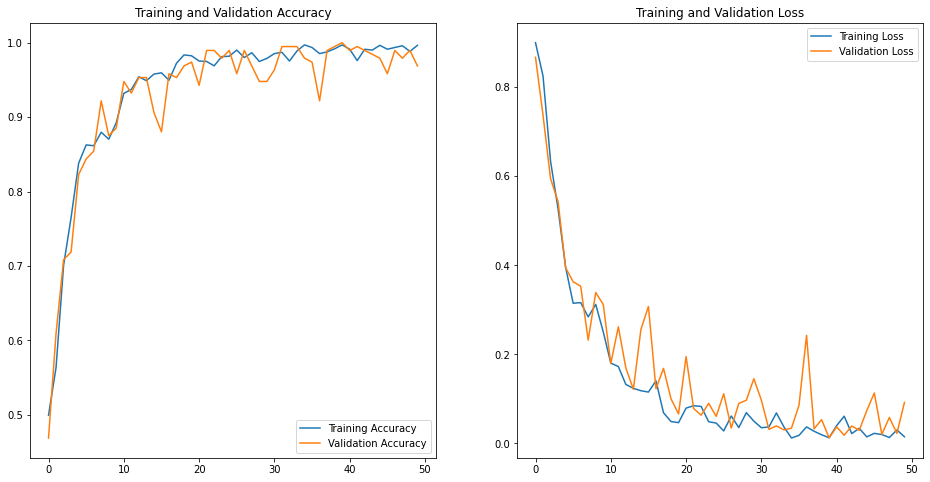

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

First image to predict:
Actual label:  Potato___Early_blight
Predicted label:  Potato___Early_blight


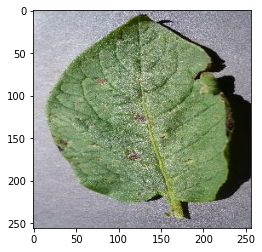

In [ ]:
for image_batch, label_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype("uint8")
  first_label = label_batch[0].numpy()

  print("First image to predict:")
  plt.imshow(first_image)
  print("Actual label: ", class_names[first_label])

  batch_pred = model.predict(image_batch)
  print("Predicted label: ", class_names[np.argmax(batch_pred[0])])

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * np.max(predictions[0]), 2)
  return predicted_class, confidence

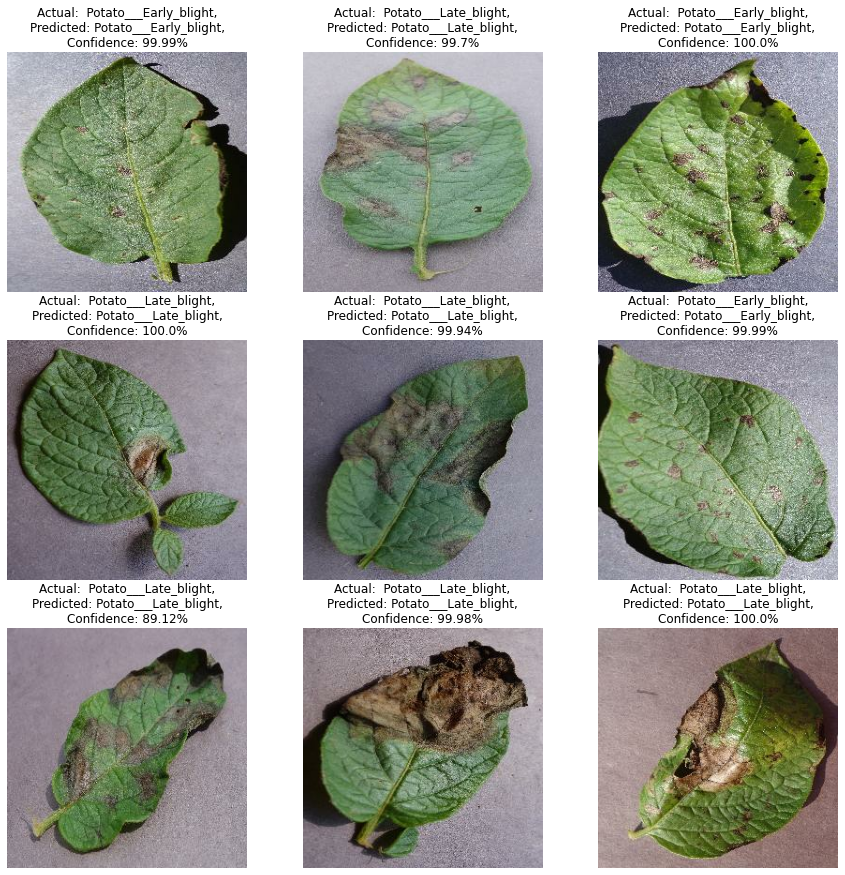

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual:  {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")

    plt.axis("off")

In [ ]:
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/models/") + [0]]) + 1
model.save(f"/content/drive/MyDrive/models/{model_version}")

In [ ]:
model.save("first.h5")

In [ ]:
print(tf.__version__)

2.8.2
